In [1]:
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
from qiskit import( ClassicalRegister,
        QuantumRegister,
        QuantumCircuit,
        execute,
        Aer,
        IBMQ,
        transpile)
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import( plot_histogram,
                        plot_state_city,
                        plot_gate_map, 
                        plot_circuit_layout,
                        circuit_drawer)
from qiskit.circuit.library import QFT
from qiskit.quantum_info.analysis import hellinger_fidelity,hellinger_distance
from qiskit.providers.aer.noise import NoiseModel
from math import (log,ceil)
from scipy.fft import fft, ifft
from scipy.linalg import dft, inv, expm, norm
from scipy.linalg.interpolative import estimate_spectral_norm
import scipy.stats as st
from numpy.linalg import matrix_power
mpl.rcParams['figure.figsize'] = 11,8
mpl.rcParams.update({'font.size' : 15})
import pandas as pd


In [2]:
def circulant_adjacency(n,v):
    iv = list(range(0,n))
    av = list(range(0,n-1))
    C = np.zeros([n,n])
    for z in range(n):
        C[z,0] = v[iv[z]]    
    for x in range(1,n):
        av = iv[0:-1]
        iv[0] = iv[-1]
        iv[1::] = av
        for y in range(0,n):
            C[y,x] = v[iv[y]]
    return C

def unitary_ctqw(gamma, N, A, marked, t): #---
    Oracle = np.zeros([N,N])
    for x in marked:
        Oracle[x,x] = 1
    U = expm(1j*(-gamma*A - Oracle)*t)
    return U

def initialCond(string,N,toGate):
    qreg = QuantumRegister(N)
    qc = QuantumCircuit(qreg)
    if string == 'H':
        qc.h(qreg)
        return qc
    for x in range(N):
        if string[x] == '1':
            qc.x(qreg[x])
    if toGate:
        qc = qc.to_gate()
        qc.name = '      INIT    '
    qc = transpile(qc)
    return qc

def diagUniOp(N,diagU0,backend,method): 
    qreg = QuantumRegister(N) 
    circ = QuantumCircuit(qreg,name='    UniOp    ') 
    circ.diagonal(diagU0,qreg)  
    circ = transpile(circ)#,optimization_level=3)#,backend=backend,layout_method=method) 
    return circ 

def contCirc(N,diagUniOp,backend,method,t,initString):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,creg)
    initCond = initialCond(initString,N,False)
    if t == 0:
        circ.append(initCond,range(N))
        circ.barrier()
        circ.measure(qreg,creg)
        circ = transpile(circ)
        return circ
    else:
        circ.append(initCond,range(N))
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=True,name='    QFT    '),range(N))
        circ.barrier()
        circ.append(diagUniOp,range(N))
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=False,name='    IQFT'    ),range(N))
        circ.barrier()
        circ.measure(qreg,creg)
        circ=transpile(circ,basis_gates=['cx','cp','rz','h','x'])
    return circ

def runWalkCirc(NCirc,walkU0,walkTime,initString,method,backend):
    walkU = np.diag(walkU0).tolist()
    walkUQiskit = diagUniOp(NCirc,walkU,backend,method)
    walkCirc = contCirc(NCirc,walkUQiskit,backend,method,walkTime,initString)
    return walkCirc

def runWalkResults(walkCirc,shots):
    walkResult = simul(walkCirc,False,shots)
    correctedResult = { int(k[::-1],2) : v/shots for k, v in walkResult.items()}
    return correctedResult

def simul(qc,stateVec,shots):
    if stateVec:
        backend = Aer.get_backend('statevector_simulator')
        result = execute(qc,backend,shots=shots).result().get_statevector(qc,decimals=3)
    else:
        backend = Aer.get_backend('qasm_simulator')
        result = execute(qc,backend,shots=shots).result().get_counts()
    return result

def correctResults(counts,shots):
    correctedResult = { int(k[::-1],2) : v/shots for k, v in counts.items()}
    return correctedResult

In [3]:
def contCircQFT(N,diagUniOp,backend,method,t,initString,approx,simul):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,creg)
    initCond = initialCond(initString,N,False)
    if t == 0:
        circ.append(initCond,range(N))
        circ.barrier()
        circ.measure(qreg,creg)
        circ = transpile(circ)
        return circ
    else:
        circ.append(initCond,range(N))
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=approx,inverse=True,name='    QFT    '),range(N))
        circ.barrier()
        circ.append(diagUniOp,range(N))
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=approx,inverse=False,name='    IQFT'    ),range(N))
        circ.barrier()
        if simul:
            circ.measure(qreg,creg)
        circ=transpile(circ,basis_gates=['cx','u3'])
    return circ

def runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,backend,approx,simul):
    walkU = np.diag(walkU0).tolist()
    walkUQiskit = diagUniOp(NCirc,walkU,backend,method)
    walkCirc = contCircQFT(NCirc,walkUQiskit,backend,method,walkTime,initString,approx,simul)
    return walkCirc

In [4]:
simulatorBackend = Aer.get_backend('qasm_simulator')
method = 'trivial'
shots = 3000
N = 8
NCirc = 3
initString = '100'
walkTime = 1
walkGamma = 1 / (2*np.sqrt(2))
cInterm = c = [0,1,1,0,0,0,1,1]
qft = dft(N,scale = 'sqrtn')
iqft = inv(qft)
A = circulant_adjacency(N,cInterm)
lambdA =  iqft@A@qft

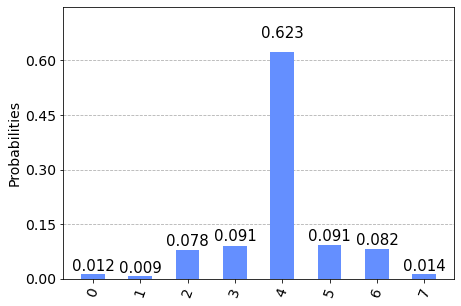

In [6]:
approxQFT = 0
walkU0 = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
walkIntermN3QFT0 = runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,simulatorBackend,approxQFT,True)
#walkCirc.draw(output='mpl')
walkResultsIntermN3QFT0 = runWalkResults(walkIntermN3QFT0,shots)

plot_histogram(walkResultsIntermN3QFT0)

In [7]:
ibmQft0 = {0: 0.094, 4: 0.4093333333333333, 2: 0.093, 6: 0.10266666666666667, 1: 0.08133333333333333, 5: 0.08333333333333333, 3: 0.09133333333333334, 7: 0.045}
ibmQft1 = {0: 0.083, 4: 0.45166666666666666, 2: 0.07, 6: 0.105, 1: 0.04066666666666666, 5: 0.10366666666666667, 3: 0.123, 7: 0.023}
ibmQft2 = {0: 0.052333333333333336, 4: 0.455, 2: 0.106, 6: 0.134, 1: 0.035333333333333335, 5: 0.069, 3: 0.05366666666666667, 7: 0.09466666666666666}

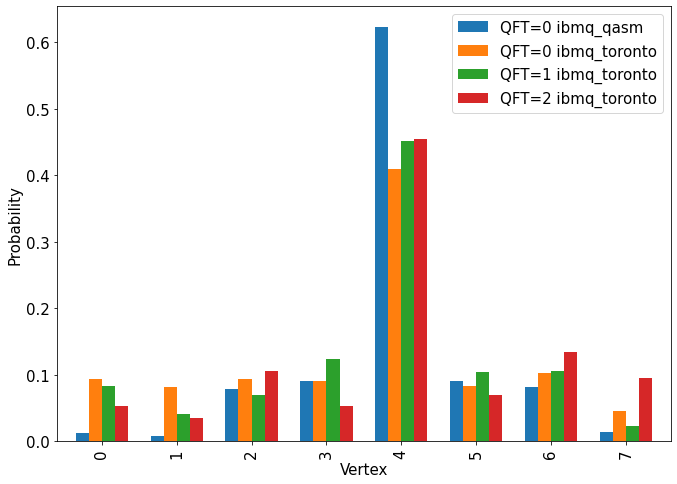

In [8]:

d = {'QFT=0 ibmq_qasm':walkResultsIntermN3QFT0, 'QFT=0 ibmq_toronto':ibmQft0, 'QFT=1 ibmq_toronto': ibmQft1, 'QFT=2 ibmq_toronto':ibmQft2}
df = pd.DataFrame(d)
ax = df.sort_index().plot(kind='bar',width=0.7)
ax.set(xlabel="Vertex", ylabel="Probability")
fig = ax.get_figure()
fig.savefig('C:/Users/Jaime/Desktop/download.png',facecolor='w')

# PGT

### Cycle

In [22]:
simulatorBackend = Aer.get_backend('qasm_simulator')
method = 'trivial'
shots = 3000
N = 8
NCirc = 3
initString = '000'
walkTime = np.pi
walkGamma = 1
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
qft = dft(N,scale = 'sqrtn')
iqft = inv(qft)
A = circulant_adjacency(N,cCycle)
lambdA =  iqft@A@qft
print(cCycle)

[0, 1, 0, 0, 0, 0, 0, 1]


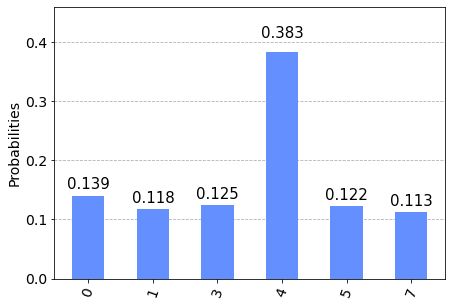

In [23]:
approxQFT = 0
walkU0 = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
walkCyclePSTN3QFT0 = runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,simulatorBackend,approxQFT,True)
#walkCirc.draw(output='mpl')
walkResultsCyclePSTN3QFT0 = runWalkResults(walkCyclePSTN3QFT0,shots)
plot_histogram(walkResultsCyclePSTN3QFT0)

In [7]:
ibmPstQft2 = {0: 0.04733333333333333, 4: 0.6676666666666666, 2: 0.020666666666666667, 6: 0.038, 1: 0.021, 5: 0.09133333333333334, 3: 0.059, 7: 0.055}

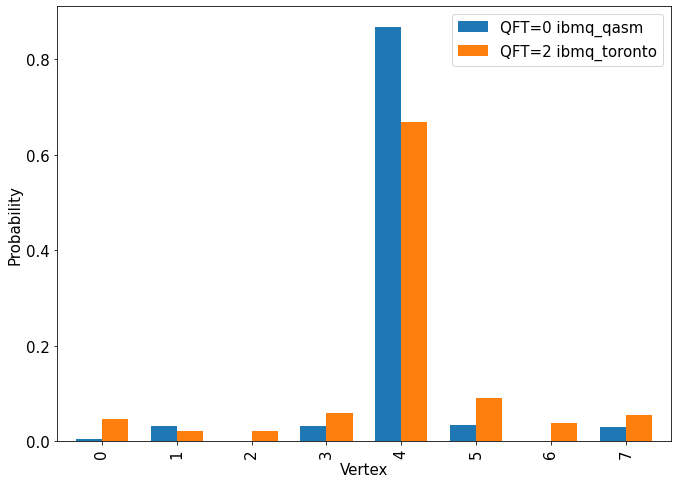

In [8]:

d = {'QFT=0 ibmq_qasm':walkResultsCyclePSTN3QFT0, 'QFT=2 ibmq_toronto':ibmPstQft2}
df = pd.DataFrame(d)
ax = df.sort_index().plot(kind='bar',width=0.7)
ax.set(xlabel="Vertex", ylabel="Probability")
fig = ax.get_figure()
fig.savefig('C:/Users/Jaime/Desktop/download.png',facecolor='w')

### [0,1,1,0,1,0,1,1]

In [28]:
simulatorBackend = Aer.get_backend('qasm_simulator')
method = 'trivial'
shots = 3000
N = 8
NCirc = 3
initString = '000'
walkTime = 2*np.pi
walkGamma = 1
cCycle = [0,1,1,0,1,0,1,1]
qft = dft(N,scale = 'sqrtn')
iqft = inv(qft)
A = circulant_adjacency(N,cCycle)
lambdA =  iqft@A@qft
print(cCycle)

[0, 1, 1, 0, 1, 0, 1, 1]


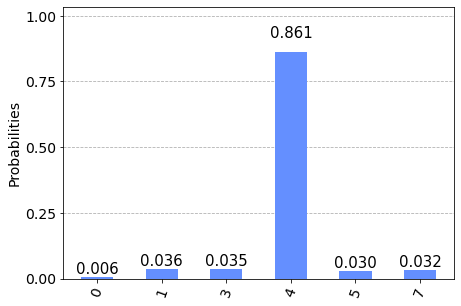

In [29]:
approxQFT = 0
walkU0 = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
walkIntermPSTN3QFT0 = runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,simulatorBackend,approxQFT,True)
#walkCirc.draw(output='mpl')
walkResultsIntermPSTN3QFT0 = runWalkResults(walkIntermPSTN3QFT0,shots)
plot_histogram([walkResultsIntermPSTN3QFT0])

In [30]:
ibmPstIntermQft2={0: 0.052, 4: 0.7263333333333334, 2: 0.016666666666666666, 6: 0.039, 1: 0.013333333333333334, 5: 0.03966666666666667, 3: 0.057, 7: 0.056}


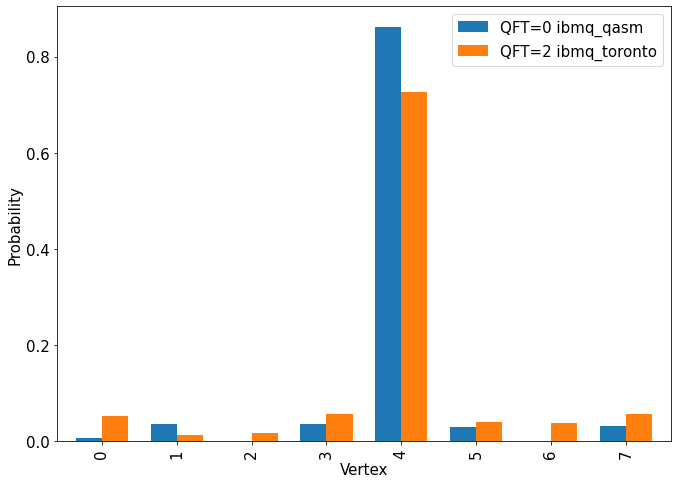

In [31]:
d = {'QFT=0 ibmq_qasm':walkResultsIntermPSTN3QFT0, 'QFT=2 ibmq_toronto':ibmPstIntermQft2}
df = pd.DataFrame(d)
ax = df.sort_index().plot(kind='bar',width=0.7)
ax.set(xlabel="Vertex", ylabel="Probability")
fig = ax.get_figure()
fig.savefig('C:/Users/Jaime/Desktop/download.png',facecolor='w')